In [95]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from collections import Counter, defaultdict
import json, csv
import numpy as np
import xmltodict
from sklearn.dummy import DummyClassifier
import random
from sklearn.metrics import precision_recall_fscore_support
import statsmodels.api as sm


import os
from statistics import mean, stdev
import warnings 
from scipy.stats import ttest_rel, levene
from collections import defaultdict
from typing import List, Dict, Tuple
from scipy import stats
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
from scipy.stats import pearsonr

warnings.filterwarnings('ignore') 

# All analysis on Gemini1-5, 5-s, Task 3 (Full Scale)

In [96]:
all_cases = pd.read_csv('../qualitative_analysis/error_and_correct_t3.csv')

In [124]:
all_cases['error_type'] = all_cases['error_type'].replace('FN', 'Missclassification')
all_cases

,dataset,id,gold,pred,argument,stance,comment,split,error_type,comment_length,is_correct
0,gm,102arg7,4,5,Marriage should be between a man and a woman,Con,Let me put it in perspective for all the Pro c...,2,Missclassification,326,0
1,gm,78arg5,5,4,Major world religions are against gay marriages,Con,I'm con because gay marriage is against the mo...,2,Missclassification,851,0
2,gm,105arg4,4,5,It is discriminatory to refuse gay couples the...,Pro,Love thy neighbor is the phrase I base this is...,2,Missclassification,290,0
3,gm,56arg4,5,4,It is discriminatory to refuse gay couples the...,Pro,I am pro because the Constution states everyon...,2,Missclassification,190,0
4,gm,76arg7,2,1,Marriage should be between a man and a woman,Con,I'm Catholic been my whole life and believe sa...,2,Missclassification,750,0
...,...,...,...,...,...,...,...,...,...,...,...
743,ugip,414721880arg1,5,5,Separation of state and religion,Con,"Religion should stay out of the public square,...",2,correct,438,1
744,ugip,414721935arg1,2,2,Separation of state and religion,Con,This country was founded on God. To take out h...,2,correct,119,1
745,ugip,414721693arg2,2,2,Removing under god would promote religious tol...,Con,This is what is wrong with America today. We a...,2,correct,604,1
746,ugip,414721759arg6,1,1,America is based on democracy and the pledge s...,Pro,The Pledge of Allegiance reflects our morals a...,2,correct,248,1


In [98]:
topic_prf1 = []

for topic in all_cases['dataset'].unique():
    df = all_cases[all_cases['dataset'] == topic]
    pr, re, f1, _ = precision_recall_fscore_support(df['gold'], df['pred'], average='macro')
    
    topic_prf1.append({
        'dataset': topic,
        'precision': pr,
        'recall': re,
        'f1': f1
    })

topic_prf1_df = pd.DataFrame(topic_prf1).round(3)
topic_prf1_df

,dataset,precision,recall,f1
0,gm,0.563,0.576,0.562
1,ugip,0.599,0.615,0.584


In [99]:
stance_prf1 = []

for stance in ['Pro', 'Con']:
    df = all_cases[all_cases['stance'] == stance]
    pr, re, f1, _ = precision_recall_fscore_support(df['gold'], df['pred'], average='macro')

    stance_prf1.append({
        'stance': stance,
        'precision': pr,
        'recall': re,
        'f1': f1
    })

stance_prf1_df = pd.DataFrame(stance_prf1).round(3)
stance_prf1_df

,stance,precision,recall,f1
0,Pro,0.500,0.511,0.479
1,Con,0.628,0.649,0.632


In [100]:
support_attack_prf1 = []

label_map = {
    1: 'Explicit Attack',
    2: 'Implicit Attack',
    4: 'Implicit Support',
    5: 'Explicit Support'
}

df_task3 = all_cases[all_cases['gold'].isin([1, 2, 4, 5])]

for label_value, label_name in label_map.items():
    df = df_task3[df_task3['gold'] == label_value]
    pr, re, f1, _ = precision_recall_fscore_support(df['gold'], df['pred'], average='macro')

    support_attack_prf1.append({
        'label': label_name,
        'precision': pr,
        'recall': re,
        'f1': f1
    })

support_attack_prf1_df = pd.DataFrame(support_attack_prf1).round(3)
support_attack_prf1_df

,label,precision,recall,f1
0,Explicit Attack,0.333,0.254,0.289
1,Implicit Attack,0.250,0.115,0.157
2,Implicit Support,0.250,0.142,0.181
3,Explicit Support,0.250,0.151,0.188


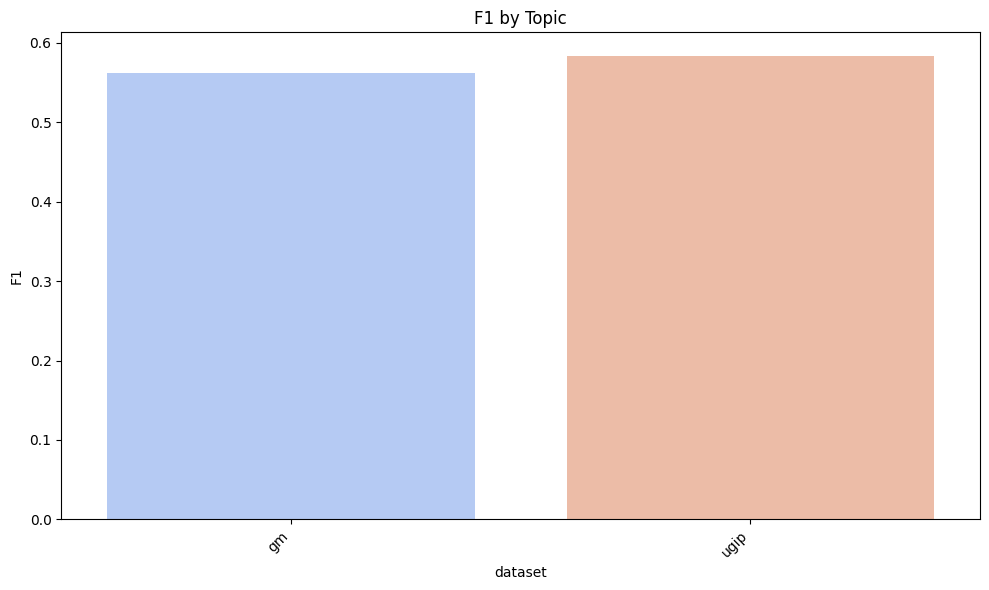

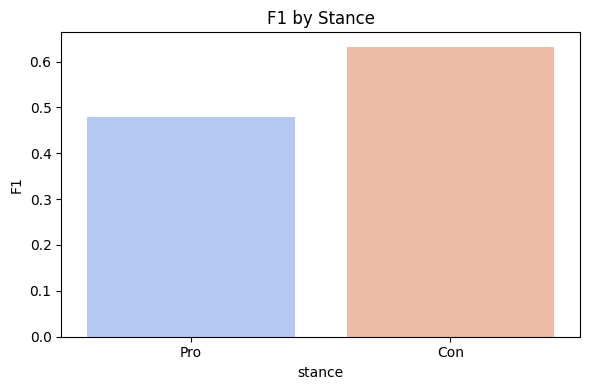

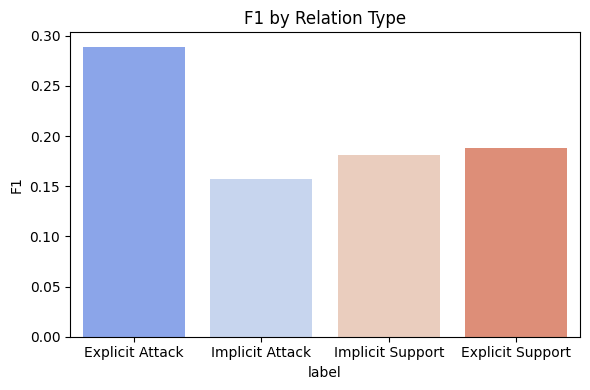

In [101]:
metrics = ['f1']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=topic_prf1_df, x='dataset', y=metric, palette='coolwarm')
    plt.title(f'{metric.capitalize()} by Topic')
    plt.ylabel(f'{metric.capitalize()}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=stance_prf1_df, x='stance', y=metric, palette='coolwarm')
    plt.title(f'{metric.capitalize()} by Stance')
    plt.ylabel(f'{metric.capitalize()}')
    plt.tight_layout()
    plt.show()
    
for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=support_attack_prf1_df, x='label', y=metric, palette='coolwarm')
    plt.title(f'{metric.capitalize()} by Relation Type')
    plt.ylabel(f'{metric.capitalize()}')
    plt.tight_layout()
    plt.show()


## Quantitative analysis

In [102]:
all_cases

,dataset,id,gold,pred,argument,stance,comment,split,error_type
0,gm,102arg7,4,5,Marriage should be between a man and a woman,Con,Let me put it in perspective for all the Pro c...,2,FN
1,gm,78arg5,5,4,Major world religions are against gay marriages,Con,I'm con because gay marriage is against the mo...,2,FN
2,gm,105arg4,4,5,It is discriminatory to refuse gay couples the...,Pro,Love thy neighbor is the phrase I base this is...,2,FN
3,gm,56arg4,5,4,It is discriminatory to refuse gay couples the...,Pro,I am pro because the Constution states everyon...,2,FN
4,gm,76arg7,2,1,Marriage should be between a man and a woman,Con,I'm Catholic been my whole life and believe sa...,2,FN
...,...,...,...,...,...,...,...,...,...
743,ugip,414721880arg1,5,5,Separation of state and religion,Con,"Religion should stay out of the public square,...",2,correct
744,ugip,414721935arg1,2,2,Separation of state and religion,Con,This country was founded on God. To take out h...,2,correct
745,ugip,414721693arg2,2,2,Removing under god would promote religious tol...,Con,This is what is wrong with America today. We a...,2,correct
746,ugip,414721759arg6,1,1,America is based on democracy and the pledge s...,Pro,The Pledge of Allegiance reflects our morals a...,2,correct


In [103]:
### 1. Effect of Argument Frequency on Accuracy

arg_counts = all_cases['argument'].value_counts().reset_index()
arg_counts.columns = ['argument', 'frequency']

def compute_f1(group):
    return f1_score(group['gold'], group['pred'], average='macro')

arg_f1 = all_cases.groupby('argument').apply(compute_f1).reset_index()
arg_f1.columns = ['argument', 'f1']

arg_analysis = pd.merge(arg_counts, arg_f1, on='argument')

corr, p_value = pearsonr(arg_analysis['frequency'], arg_analysis['f1'])
print(f"Correlation between argument frequency and F1: {corr:.4f} (p={p_value:.4f})")

Correlation between argument frequency and F1: 0.5541 (p=0.0494)


- Stronger positive effect of frequency

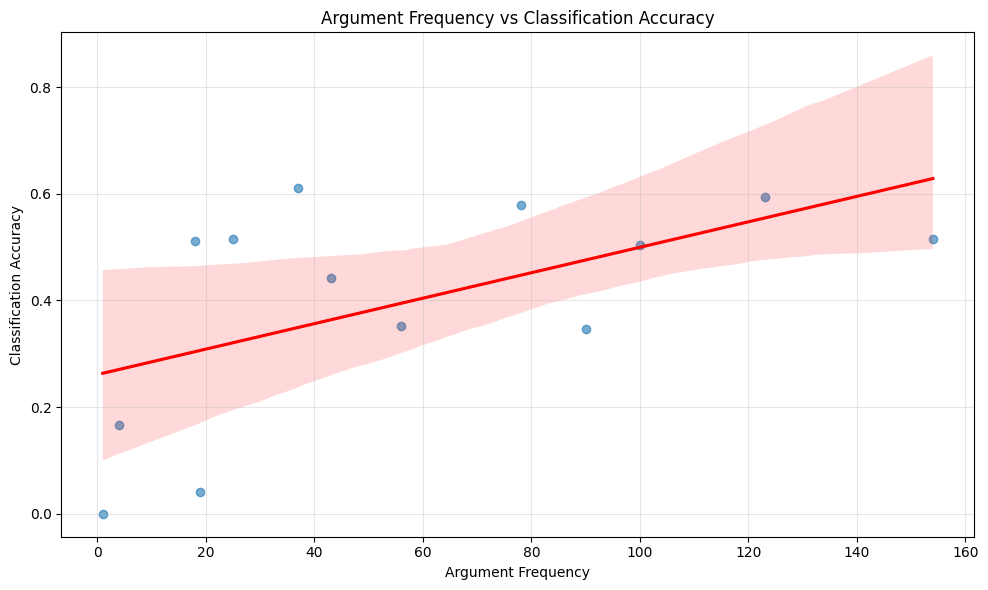

In [104]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=arg_analysis, 
    x='frequency', 
    y='f1', 
    scatter_kws={'alpha':0.6}, 
    line_kws={'color':'red'}
)
plt.xlabel('Argument Frequency')
plt.ylabel('Classification Accuracy')
plt.title('Argument Frequency vs Classification Accuracy')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [105]:
arg_analysis

,argument,frequency,f1
0,Marriage should be between a man and a woman,154,0.515265
1,Separation of state and religion,123,0.593246
2,It is discriminatory to refuse gay couples the...,100,0.504681
3,Under God is part of American tradition and h...,90,0.347026
4,Major world religions are against gay marriages,78,0.578376
5,America is based on democracy and the pledge s...,56,0.352114
6,Removing under god would promote religious tol...,43,0.441192
7,"Marriage is about more than procreation, there...",37,0.610740
8,Gay couples should be able to take advantage o...,25,0.515313
9,Gay couples can declare their union without re...,19,0.041667


In [106]:
### 2. Single Argument Performance

worst_args = arg_analysis.sort_values('f1').head(10)
best_args = arg_analysis.sort_values('f1', ascending=False).head(10)


arg_topics = all_cases.groupby('argument')['dataset'].first().reset_index()
arg_analysis = pd.merge(arg_analysis, arg_topics, on='argument')

topic_counts = all_cases['dataset'].value_counts().reset_index()
topic_counts.columns = ['dataset', 'topic_total']

arg_analysis = pd.merge(arg_analysis, topic_counts, on='dataset')

arg_analysis['topic_proportion'] = arg_analysis['frequency'] / arg_analysis['topic_total']

worst_args = arg_analysis.sort_values('f1').head(10)[['argument', 'f1', 'frequency', 'topic_proportion', 'dataset']]
best_args = arg_analysis.sort_values('f1', ascending=False).head(10)[['argument', 'f1', 'frequency', 'topic_proportion', 'dataset']]

In [107]:
worst_args

,argument,f1,frequency,topic_proportion,dataset
12,Implies ultimate power on the part of the state,0.000000,1,0.003155,ugip
9,Gay couples can declare their union without re...,0.041667,19,0.044084,gm
11,Likely to be seen as a state sanctioned condem...,0.166667,4,0.012618,ugip
3,Under God is part of American tradition and h...,0.347026,90,0.283912,ugip
5,America is based on democracy and the pledge s...,0.352114,56,0.176656,ugip
6,Removing under god would promote religious tol...,0.441192,43,0.135647,ugip
2,It is discriminatory to refuse gay couples the...,0.504681,100,0.232019,gm
10,Gay marriage undermines the institution of mar...,0.511905,18,0.041763,gm
0,Marriage should be between a man and a woman,0.515265,154,0.357309,gm
8,Gay couples should be able to take advantage o...,0.515313,25,0.058005,gm


In [108]:
def compute_f1_stance(group):
    return f1_score(group['gold'], group['pred'], average='macro')

stance_f1 = all_cases.groupby('stance').apply(compute_f1_stance).reset_index()
stance_f1.columns = ['stance', 'f1']

stance_errors = all_cases.groupby(['stance', 'error_type']).size().unstack().fillna(0)
stance_errors_pct = stance_errors.div(stance_errors.sum(axis=1), axis=0)

stance_preds = pd.crosstab(all_cases['stance'], all_cases['pred'])
stance_preds_pct = stance_preds.div(stance_preds.sum(axis=1), axis=0)

print("F1 by stance:")
print(stance_f1)
print("\nPrediction distribution by stance:")
print(stance_preds_pct)

F1 by stance:
  stance        f1
0    Con  0.632269
1    Pro  0.478516

Prediction distribution by stance:
pred           1         2         4         5
stance                                        
Con     0.204128  0.208716  0.238532  0.348624
Pro     0.336538  0.099359  0.304487  0.259615


In [109]:
dataset_f1 = all_cases.groupby('dataset').apply(
    lambda x: f1_score(x['gold'], x['pred'], average='macro')
).reset_index()
dataset_f1.columns = ['dataset', 'f1']

dataset_errors = all_cases.groupby(['dataset', 'error_type']).size().unstack().fillna(0)
dataset_errors_pct = dataset_errors.div(dataset_errors.sum(axis=1), axis=0)

dataset_stance_f1 = all_cases.groupby(['dataset', 'stance']).apply(
    lambda x: f1_score(x['gold'], x['pred'], average='macro')
).reset_index()
dataset_stance_f1.columns = ['dataset', 'stance', 'f1']

print("F1 by dataset:")
print(dataset_f1)
print("\nError type distribution by dataset:")
print(dataset_errors_pct)

F1 by dataset:
  dataset        f1
0      gm  0.561609
1    ugip  0.584130

Error type distribution by dataset:
error_type        FN   correct
dataset                       
gm          0.403712  0.596288
ugip        0.406940  0.593060


<Figure size 1200x600 with 0 Axes>

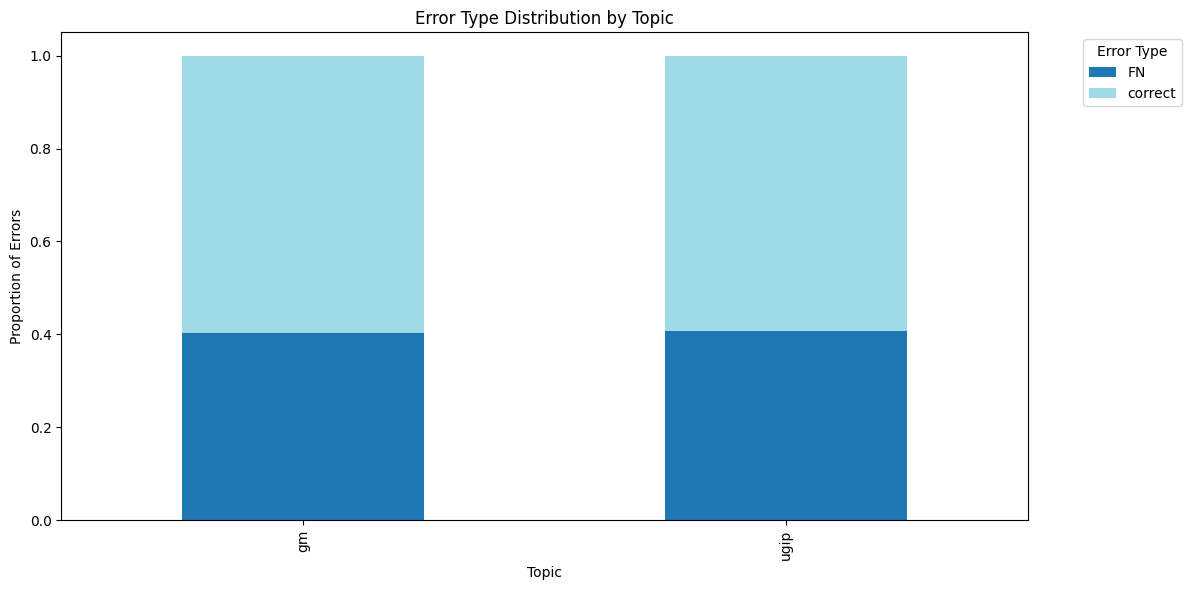

In [110]:
plt.figure(figsize=(12, 6))
dataset_errors_pct.plot(kind='bar', stacked=True, colormap='tab20', figsize=(12, 6))
plt.title('Error Type Distribution by Topic')
plt.xlabel('Topic')
plt.ylabel('Proportion of Errors')
plt.legend(title='Error Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

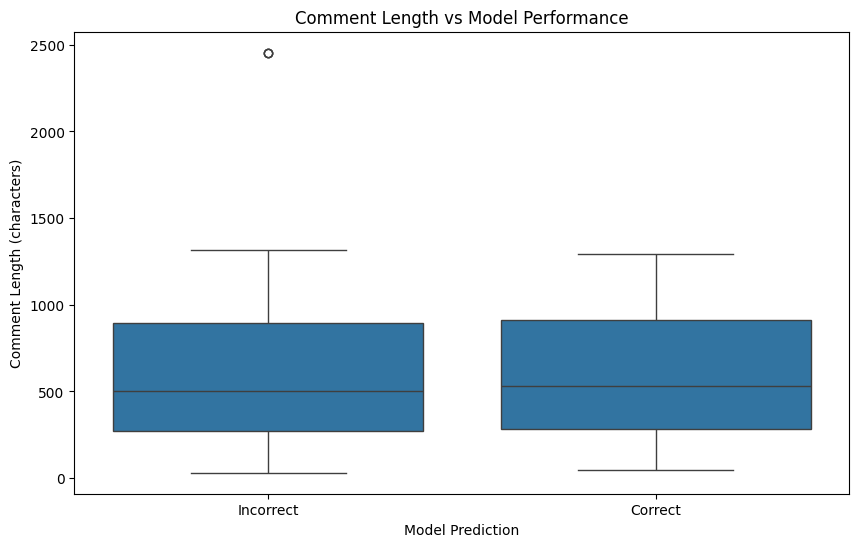

In [112]:
all_cases["comment_length"] = all_cases["comment"].str.len()
all_cases = all_cases[all_cases['comment'].str.len() <= 5000]

all_cases["is_correct"] = all_cases["error_type"].apply(lambda x: 1 if x == "correct" else 0)
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_cases, x="is_correct", y="comment_length")
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.xlabel("Model Prediction")
plt.ylabel("Comment Length (characters)")
plt.title("Comment Length vs Model Performance")
plt.show()

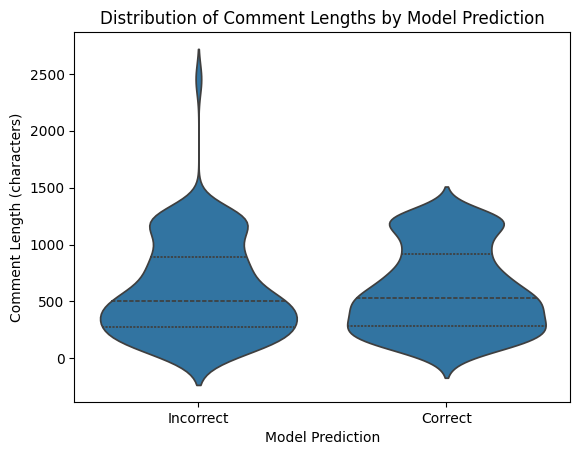

In [113]:
sns.violinplot(data=all_cases, x="is_correct", y="comment_length", inner="quartile")
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.xlabel("Model Prediction")
plt.ylabel("Comment Length (characters)")
plt.title("Distribution of Comment Lengths by Model Prediction")
plt.show()

In [114]:
from scipy.stats import ttest_ind

correct_lengths = all_cases[all_cases["is_correct"] == 1]["comment_length"]
incorrect_lengths = all_cases[all_cases["is_correct"] == 0]["comment_length"]

t_stat, p_value = ttest_ind(correct_lengths, incorrect_lengths, equal_var=False)
print(f"T-test result: t={t_stat:.3f}, p={p_value:.4f}")

T-test result: t=-0.121, p=0.9037


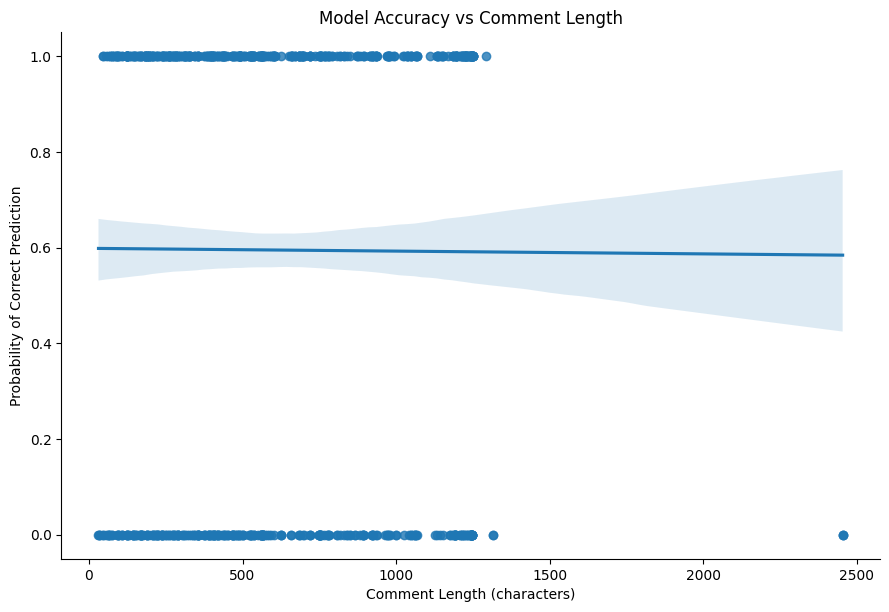

In [115]:
sns.lmplot(data=all_cases, x="comment_length", y="is_correct", logistic=True, height=6, aspect=1.5)
plt.xlabel("Comment Length (characters)")
plt.ylabel("Probability of Correct Prediction")
plt.title("Model Accuracy vs Comment Length")
plt.show()

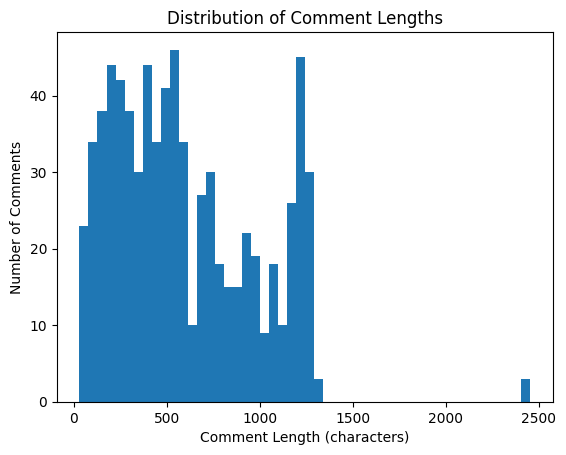

In [116]:
all_cases['comment_length'] = all_cases['comment'].str.len()

plt.hist(all_cases['comment_length'], bins=50)
plt.xlabel('Comment Length (characters)')
plt.ylabel('Number of Comments')
plt.title('Distribution of Comment Lengths')
plt.show()

# Qualitative analysis

In [121]:
all_cases

,dataset,id,gold,pred,argument,stance,comment,split,error_type,comment_length,is_correct
0,gm,102arg7,4,5,Marriage should be between a man and a woman,Con,Let me put it in perspective for all the Pro c...,2,FN,326,0
1,gm,78arg5,5,4,Major world religions are against gay marriages,Con,I'm con because gay marriage is against the mo...,2,FN,851,0
2,gm,105arg4,4,5,It is discriminatory to refuse gay couples the...,Pro,Love thy neighbor is the phrase I base this is...,2,FN,290,0
3,gm,56arg4,5,4,It is discriminatory to refuse gay couples the...,Pro,I am pro because the Constution states everyon...,2,FN,190,0
4,gm,76arg7,2,1,Marriage should be between a man and a woman,Con,I'm Catholic been my whole life and believe sa...,2,FN,750,0
...,...,...,...,...,...,...,...,...,...,...,...
743,ugip,414721880arg1,5,5,Separation of state and religion,Con,"Religion should stay out of the public square,...",2,correct,438,1
744,ugip,414721935arg1,2,2,Separation of state and religion,Con,This country was founded on God. To take out h...,2,correct,119,1
745,ugip,414721693arg2,2,2,Removing under god would promote religious tol...,Con,This is what is wrong with America today. We a...,2,correct,604,1
746,ugip,414721759arg6,1,1,America is based on democracy and the pledge s...,Pro,The Pledge of Allegiance reflects our morals a...,2,correct,248,1


In [125]:
error_samples = all_cases[all_cases['error_type'].isin(['Missclassification'])].groupby('dataset').apply(
    lambda x: x.sample(min(8, len(x)))
).reset_index(drop=True)

os.makedirs("qualitative_analysis", exist_ok=True)
error_samples.to_csv("qualitative_analysis/error_samples_t3.csv", index=False, encoding='utf-8')

In [126]:
error_samples

,dataset,id,gold,pred,argument,stance,comment,split,error_type,comment_length,is_correct
0,gm,5arg4,4,5,It is discriminatory to refuse gay couples the...,Pro,A lot of the comments I see on the right have ...,2,Missclassification,624,0
1,gm,188arg7,5,4,Marriage should be between a man and a woman,Con,its genetically not right to be gay you cant h...,2,Missclassification,124,0
2,gm,63arg5,5,4,Major world religions are against gay marriages,Con,I don't believe in gay marriage. Here's why: T...,2,Missclassification,840,0
3,gm,36arg5,1,4,Major world religions are against gay marriages,Con,Gay vs Straight marriage is primarily a religi...,2,Missclassification,1245,0
4,gm,115arg5,5,4,Major world religions are against gay marriages,Con,"NO!Accord to the Holy Bible, it is an ambomina...",2,Missclassification,64,0
5,gm,102arg7,4,5,Marriage should be between a man and a woman,Con,Let me put it in perspective for all the Pro c...,2,Missclassification,326,0
6,gm,105arg4,4,5,It is discriminatory to refuse gay couples the...,Pro,Love thy neighbor is the phrase I base this is...,2,Missclassification,290,0
7,gm,32arg2,2,1,Gay couples should be able to take advantage o...,Pro,Gay marriage should not be legal because homos...,2,Missclassification,439,0
8,ugip,414721846arg3,2,1,Under God is part of American tradition and h...,Pro,'God' is not an irrefutable fact; it is a pers...,2,Missclassification,561,0
9,ugip,414721761arg6,1,2,America is based on democracy and the pledge s...,Pro,It should be taken out. This is NOT a christia...,2,Missclassification,527,0
